<a href="https://colab.research.google.com/github/nick880107-git/AI_Study-Works/blob/master/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 調用GPU Server

In [38]:
!nvidia-smi

Thu Dec  3 13:19:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Darknet預處理

### 複製Darknet

In [2]:
! git clone https://github.com/pjreddie/darknet.git
! cd darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5916, done.
remote: Total 5916 (delta 0), reused 0 (delta 0), pack-reused 5916
Receiving objects: 100% (5916/5916), 6.34 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (3916/3916), done.


### 修改Darknet 中的Makefile

In [3]:
! sed -i "s/GPU=0/GPU=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN=0/CUDNN=1/g" /content/darknet/Makefile
! sed -i "s/OPENCV=0/OPENCV=1/g" /content/darknet/Makefile
! head /content/darknet/Makefile

GPU=1
CUDNN=1
OPENCV=1
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


### 編譯YOLO

In [4]:
! cd darknet;make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN 

# 掛載雲端硬碟

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 在colab創建資料夾，存放後續YOLO需要的檔案

In [6]:
! rm -rf /content/yolo  #空間初始化，刪除已有的資料夾
! mkdir /content/yolo   #重新創建資料夾

### 處理voc格式檔案

In [7]:
from bs4 import BeautifulSoup
import os
import shutil

status_dic ={'happy':0, 'sad':1, 'angry':2} #將要篩選的label及對應值存放至dict                 
def getYoloFormat(filename,label_path,img_path,yolo_path,newname):  #原檔案名稱,xml路徑,img路徑,欲輸出yolo格式的位置,欲更改的檔案名稱
  
  #使用BeautifulSoup讀取xml檔案，並抓取其內容
  with open(label_path + filename,'r') as f:          
    soup=BeautifulSoup(f.read(),'xml')              
    imgname = soup.select_one("filename").text
    image_w = int(soup.select_one('width').text)
    image_h = int(soup.select_one('height').text)
    
    #創建一array，並透過迴圈存取圖片中標註的所有label資料
    ary=[]                    
    for obj in soup.select('object'):
      xmin = int(obj.select_one('xmin').text)
      xmax = int(obj.select_one('xmax').text)
      ymin = int(obj.select_one('ymin').text)
      ymax = int(obj.select_one('ymax').text)
      objclass = status_dic.get(obj.select_one('name').text)

      #voc to yolo
      x = (xmin + (xmax-xmin)/2) * 1.0 / image_w  
      y = (ymin + (ymax-ymin)/2) * 1.0 / image_h
      w = (xmax-xmin) * 1.0 / image_w
      h = (ymax-ymin) * 1.0 / image_h
      ary.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)])) 

      if os.path.exists(img_path + imgname):
        shutil.copyfile(img_path + imgname, yolo_path + newname + '.jpg')
        with open(yolo_path + newname + '.txt', 'w') as f:
          f.write('\n'.join(ary))

#### 讀取指定位址檔案轉換成yolo格式

In [8]:
import os
labelpath = '/content/drive/My Drive/Colab Notebooks/yolo/labels/'
imgpath = '/content/drive/My Drive/Colab Notebooks/yolo/images/'
yolopath = '/content/yolo/'

ary=[]
for idx, f in enumerate(os.listdir(labelpath)):
  try:
    getYoloFormat(f,labelpath,imgpath,yolopath,str(idx))
  except Exception as e:
    print(e)

# 準備訓練與測試資料集

In [9]:
! rm -rf /content/cfg #一樣先初始化
! mkdir /content/cfg

In [10]:
import os

#讀取所有資料，並將80%的資料作為訓練集存入train.txt,20%的資料做為測試集存入test.txt
datasets = ['/content/yolo/'+f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
index=int(len(datasets)* 0.8)

with open('/content/cfg/train.txt','w') as f:
  f.write('\n'.join(datasets[0:index]))
with open('/content/cfg/test.txt','w') as f:
  f.write('\n'.join(datasets[index:]))


# 準備參數檔案

### obj.data & obj.names

In [22]:
# 將放在雲端的兩個檔案複製到VM空間中
! cp "/content/drive/My Drive/Colab Notebooks/yolo/cfg/obj.data" cfg/
! cp "/content/drive/My Drive/Colab Notebooks/yolo/cfg/obj.names" cfg/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 351 kB of archives.
After this operation, 1,267 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dos2unix amd64 7.3.4-3 [351 kB]
Fetched 351 kB in 2s (194 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package dos2unix.
(Reading database ... 144793 files and directories curren

# 修改yolov3-tiny.cfg


*   filters=(classes+5)*3




In [13]:
! mkdir /content/cfg/weights
! cp /content/darknet/cfg/yolov3-tiny.cfg /content/cfg/
! sed -i '127s/255/24/' /content/cfg/yolov3-tiny.cfg
! sed -i '135s/80/3/' /content/cfg/yolov3-tiny.cfg
! sed -i '171s/255/24/' /content/cfg/yolov3-tiny.cfg
! sed -i '177s/80/3/' /content/cfg/yolov3-tiny.cfg
! sed -n -e 127p -e 135p -e 171p -e 177p /content/cfg/yolov3-tiny.cfg

filters=24
classes=3
filters=24
classes=3


### 因為windows和unix編碼不同，故在colab上我們使用dos2unix將這些參數轉變成unix編碼

In [31]:
! sudo apt install dos2unix
! dos2unix /content/cfg/obj.data
! dos2unix /content/cfg/obj.names
! dos2unix /content/cfg/train.txt
! dos2unix /content/cfg/test.txt
! dos2unix /content/cfg/yolov3-tiny.cfg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dos2unix is already the newest version (7.3.4-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
dos2unix: converting file /content/cfg/obj.data to Unix format...
dos2unix: converting file /content/cfg/obj.names to Unix format...
dos2unix: converting file /content/cfg/train.txt to Unix format...
dos2unix: converting file /content/cfg/test.txt to Unix format...
dos2unix: converting file /content/cfg/yolov3-tiny.cfg to Unix format...


# 複製權重


*   使用darknet53作為預訓練模型




In [14]:
# 可以透過get直接在colab下載
# !wget https://pjreddie.com/media/files/darknet53.conv.74 

# 或是上傳到雲端，從雲端直接複製
!cp "/content/drive/My Drive/Colab Notebooks/yolo/cfg/darknet53.conv.74" /content/cfg

# 訓練模型


*   /darknet detector train (data_cfg) (model_cfg) (weights)



In [32]:
! darknet/darknet detector train /content/cfg/obj.data /content/cfg/yolov3-tiny.cfg /content/cfg/darknet53.conv.74

串流輸出內容已截斷至最後 5000 行。
Region 23 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
91032: 0.036623, 0.171823 avg, 0.001000 rate, 0.015540 seconds, 91032 images
Loaded: 0.000797 seconds
Region 16 Avg IOU: 0.832833, Class: 0.995278, Obj: 0.988115, No Obj: 0.003037, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 23 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
91033: 0.038362, 0.158477 avg, 0.001000 rate, 0.022074 seconds, 91033 images
Loaded: 0.003765 seconds
Region 16 Avg IOU: 0.704644, Class: 0.999040, Obj: 0.763143, No Obj: 0.007912, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 23 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
91034: 0.370979, 0.179727 avg, 0.001000 rate, 0.019853 seconds, 91034 images
Loaded: 0.001615 seconds
Region 16 Avg IOU: 0.913444, Class: 0.999074, Obj: 0.994825, No Obj: 0.005307, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 23 Avg

# 測試模型


*   ! cd darknet



In [77]:
! cd darknet; ./darknet detector test /content/cfg/obj.data /content/cfg/yolov3-tiny.cfg /content/cfg/weights/yolov3-tiny_90000.weights /content/yolo/15.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

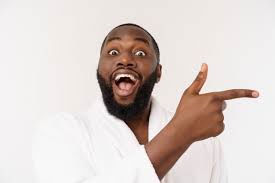

In [82]:
# 因為colab不會直接呈現圖片結果，需另外使用套件
from PIL import Image
Image.open('/content/darknet/predictions.jpg')

2 0.5621242484969939 0.2866666666666667 0.5470941883767535 0.4613333333333333

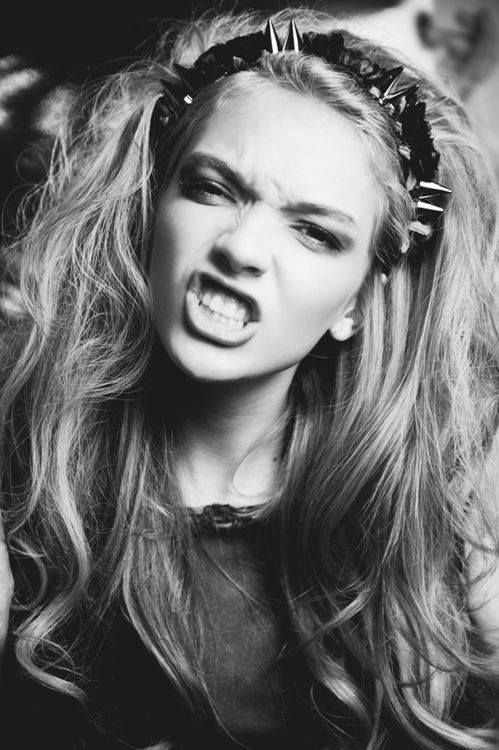

In [87]:
!cat /content/yolo/0.txt
Image.open("/content/yolo/0.jpg")